In [1]:
setwd("../Data")

mydrias<-read.csv("tasmintasmaxtaspr_metro_IPSL_WRF_histo_QT_REF_19750101-19851231.txt", header = FALSE, sep=";", skip=62)
#mydrias <- read.csv("tasmintasmaxtaspr_metro_IPSL_WRF_histo_QT_REF_19750101-19851231.txt", header = FALSE, skip=62)

colnames(mydrias) <- c("date","idpt","lat","lon","alti","Tn","Tx","Tm","RR") ## A adapter en fonction de vos données
head(mydrias)

,date,idpt,lat,lon,alti,Tn,Tx,Tm,RR
,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,01/01/1975,9378,46.2218,3.94455,302,-3.32,2.16,-0.78,0.00
2,02/01/1975,9378,46.2218,3.94455,302,-3.17,2.93,-0.90,0.00
3,03/01/1975,9378,46.2218,3.94455,302,-4.36,-1.67,-2.78,0.00
4,04/01/1975,9378,46.2218,3.94455,302,-5.40,-0.32,-3.27,0.00
5,05/01/1975,9378,46.2218,3.94455,302,-2.70,2.52,-0.02,1.06
6,06/01/1975,9378,46.2218,3.94455,302,-2.41,4.47,1.06,0.00


In [2]:
dim(mydrias)

[1] 1996946       9

In [3]:
## ajout des jours juliens au dataframe mydrias qui contient les données climat
## attention ici de bien vérifier comment vos dates sont organisées
mydrias$doi <- as.integer(format(as.Date(as.character(mydrias$date),"%d/%m/%Y"),"%j"))

In [4]:
### Pour eviter d'avoir à chaque fois à lancer les lignes précendentes
### nous allons sauvegarder l'objet mydrias dand le format des fichiers R
save(mydrias, file = "mydrias.RData")

In [5]:
load("../Data/mydrias.RData")


In [6]:
## Vérification que Tx > Tn
indn <- which(mydrias$Tn>mydrias$Tx)
length(mydrias$Tx[indn])
## si length(mydrias$Tx[indn]) > 0 donc il y a des jours pour lesquels
## Tn > Tx ce qui est bien évidemment un problème et pose question
## A votre avis à quoi cela peut-il être du ?

[1] 1553

In [7]:
## Charge la fonction de calcul de l'ETP Hargreaves
source("../FonctionsR/ETPHargreaves.R")

In [8]:
ls() ## liste des objets chargés dans 

[1] "etht"    "etmh"    "indn"    "mydrias"

In [9]:
etht ## détail sur la fonction de calcul de l'ETP

function (tn, tx, latdeg, doy, a = 0.0023) 
{
    lat = latdeg * pi/180
    gsc = 0.082
    t_m = (tn + tx)/2
    d_r = 1 + 0.033 * cos(2 * pi * doy/365)
    del = 0.409 * sin(2 * pi * doy/365 - 1.39)
    om = acos(-tan(lat) * tan(del))
    om[is.nan(om)] <- c(pi - 10^-9, 10^-9)[((latdeg[is.nan(om)] * 
        del) < 0) + 1]
    Ga = ((24 * 60)/pi) * gsc * d_r * (om * sin(lat) * sin(del) + 
        cos(lat) * cos(del) * sin(om))
    Ga[Ga < 0] <- 0
    et0 = a * Ga/2.45 * (t_m + 17.8) * sqrt(tx - tn)
    et0 = pmax(et0, 0)
    return(et0)
}

In [10]:
## La fonction etht calcule l'ETP au pas de temps journalier
## les arguments de la fonction sont : tn, tx, latitude en degré décimal et jour de l'année
## Nous utiliserons ici la fonction de R mapply qui permet d'appliquer itérativement une fontion
## nécessitant plusieurs argument. Cette fonction évite donc l'utilisation de boucle for moins efficace 
## en particulier pour des gros dataframes
## utilisation de la fonction suppressWarnings afin d'éviter l'affichage des messages d'alerte

suppressWarnings(ETP0 <- mapply(etht, tn=mydrias$Tn, tx=mydrias$Tx, latdeg=mydrias$lat, doy=mydrias$doi))

In [11]:
## check des résultats vérification de présence de NaN
## NaN problème dans le calcul lié au fait que pour certains jours
## tn > tx
length(which(is.nan(ETP0)))

[1] 1553

In [12]:
## si présence de NaN -> remplace NaN par des NA
ETP0[is.nan(ETP0)] <- NA

In [13]:
## Charge la librairie zoo afin d'utiliser la fonction na.approx pour remplacer
## les NAs par une valeur approximée par une méthode d'interpolation linéaire
library(zoo)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [14]:
## Remplacement des NAs par interpolation linéaire
ETP0 <- na.approx(ETP0)
length(which(is.nan(ETP0)))

[1] 0

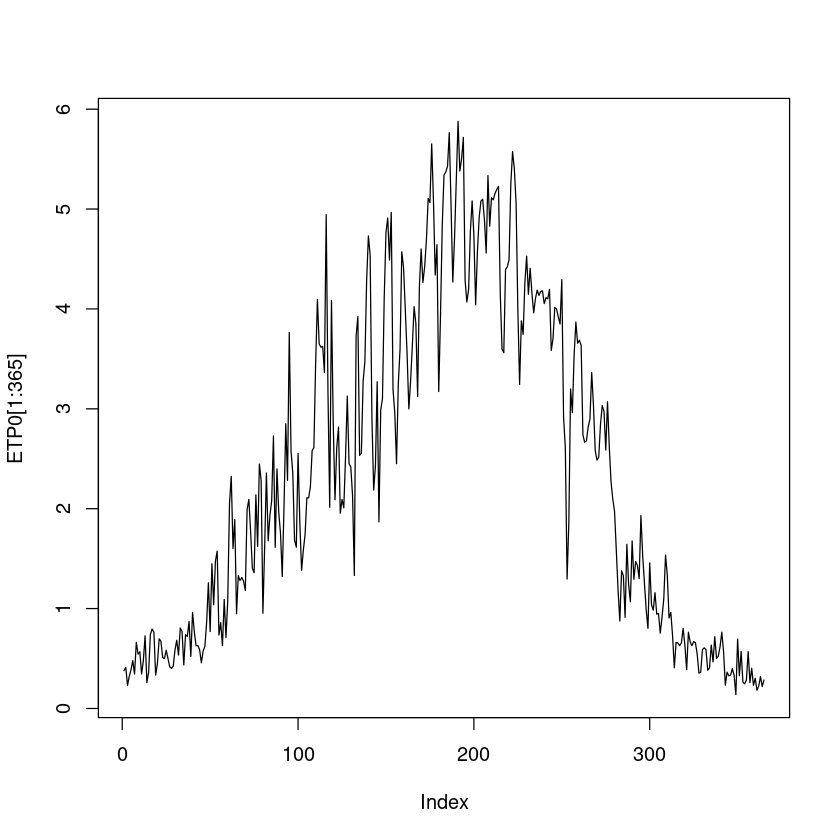

In [15]:
## Vérification des résultats. Trace les valeurs d'ETP pour les 365 premiers jours
## Cela vous parait-il cohérent ?
plot(ETP0[1:365],type="l")

In [16]:
ls()

[1] "etht"    "etmh"    "ETP0"    "indn"    "mydrias"

In [17]:
#### Ajout de l'ETP au dataframe mydrias
mydrias$ETP <- ETP0

In [18]:
head(mydrias)

,date,idpt,lat,lon,alti,Tn,Tx,Tm,RR,doi,ETP
,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,01/01/1975,9378,46.2218,3.94455,302,-3.32,2.16,-0.78,0.00,1,0.3786427
2,02/01/1975,9378,46.2218,3.94455,302,-3.17,2.93,-0.90,0.00,2,0.4124123
3,03/01/1975,9378,46.2218,3.94455,302,-4.36,-1.67,-2.78,0.00,3,0.2303775
4,04/01/1975,9378,46.2218,3.94455,302,-5.40,-0.32,-3.27,0.00,4,0.3219287
5,05/01/1975,9378,46.2218,3.94455,302,-2.70,2.52,-0.02,1.06,5,0.3894383
6,06/01/1975,9378,46.2218,3.94455,302,-2.41,4.47,1.06,0.00,6,0.4787473


In [19]:
########################################################################
## Récupération des données de Kc (cf. script kcjj.R))
####################################################################
load("Kc.RData")

In [20]:
ls()

[1] "etht"    "etmh"    "ETP0"    "indn"    "Kc"      "mydrias"

In [21]:
## jointure des données de kc aux données drias
## on utilise ici le doi (jour de l'année) comme
## clef de jointure afin d'attribuer le bon Kc au bon jour
mydrias <- merge(mydrias, Kc, by.x = "doi", by.y = "doi")

In [22]:
head(mydrias)

,doi,date,idpt,lat,lon,alti,Tn,Tx,Tm,RR,ETP,kcc,kcl,kcs
,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,01/01/1975,9378,46.2218,3.94455,302,-3.32,2.16,-0.78,0.00,0.3786427,0.2,0.2,0.1999332
2,1,01/01/1977,10667,46.8663,4.17368,301,-7.10,-2.53,-4.88,0.00,0.2505549,0.2,0.2,0.1999332
3,1,01/01/1980,10952,47.0118,4.07341,624,3.16,4.84,4.46,3.79,0.2527089,0.2,0.2,0.1999332
4,1,01/01/1977,11520,47.3052,3.65968,206,-6.86,-2.07,-4.47,0.00,0.2561628,0.2,0.2,0.1999332
5,1,01/01/1982,12530,47.7939,4.63307,332,0.99,2.65,1.94,0.00,0.2148899,0.2,0.2,0.1999332
6,1,01/01/1985,11961,47.4995,4.93907,398,-6.85,-2.74,-5.07,0.00,0.2285127,0.2,0.2,0.1999332


In [23]:
## Calcul de l'ETM = ETP x Kc
mydrias$ETM <- mydrias$ETP * mydrias$kcl

In [24]:
## Sauvegarde de mydrias 
save(mydrias,file="mydrias.RData")
## A ce stade il ne reste plus qu'à récupérer la taille du réservoir i.e.RU
## La RU a été calculé pour chaque point de grille avec QGIS

In [25]:
######################################################################
## Récupération des données de RU pour chaque point (cf. traitement QGIS)
## lecture du shapefile contenant les valeur de RU par point de grille
## Nous allons utiliser le package maptools de R qui permet de lire 
## des données spatiales issues d'un SIG comme QGIS
######################################################################
library(maptools)

Loading required package: sp

Checking rgeos availability: TRUE



In [26]:
ptdriasRU <- readShapePoly('RU_drias.shp')

Warning message:
“readShapePoly is deprecated; use rgdal::readOGR or sf::st_read”
Field name: ‘_stdev’ changed to: ‘X_stdev’



In [29]:
## Récupération des données de la table contenat les valeur de RU 
## ainsique les identifiants des points de grille
RU <- ptdriasRU@data
## Sélection de l'identifiant, de la valeur moyenne et de la valeur majoritaire
## faite une head(RU pour mettre les bons noms des colonnes)
RU <- RU[,c("idpt","ru_mean","ru_majorit")]

In [32]:
## Jointure des données de RU à mydrias
mydrias <- merge(mydrias, RU, by.x = "idpt", by.y = "idpt")

In [33]:
head(mydrias)

,idpt,doi,date,lat,lon,alti,Tn,Tx,Tm,RR,ETP,kcc,kcl,kcs,ETM,ru_mean,ru_majorit
,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9378,1,01/01/1975,46.2218,3.94455,302,-3.32,2.16,-0.78,0.00,0.3786427,0.20,0.2000000,0.1999332,0.07572854,103.8224,106
2,9378,312,08/11/1983,46.2218,3.94455,302,5.10,12.83,10.09,7.66,0.9535886,0.35,0.2338710,0.2161277,0.22301669,103.8224,106
3,9378,292,18/10/1980,46.2218,3.94455,302,1.77,5.78,4.07,0.22,0.7303612,0.35,0.3306452,0.3184270,0.24149039,103.8224,106
4,9378,155,04/06/1975,46.2218,3.94455,302,8.64,15.23,12.49,0.18,2.9612793,0.68,1.0154839,1.0477081,3.00713141,103.8224,106
5,9378,286,13/10/1979,46.2218,3.94455,302,5.53,18.93,11.50,0.00,2.0166078,0.65,0.3700000,0.3672705,0.74614489,103.8224,106
6,9378,363,29/12/1983,46.2218,3.94455,302,-2.14,9.90,3.76,0.00,0.6968727,0.20,0.2000000,0.2013706,0.13937454,103.8224,106


In [34]:
## Sauvegarde de mydrias complet i.e. avec l'ensemble des données nécessaires
## pour faire le calcul du bilan hydrique au pas de temps journalier
save(mydrias,file="mydrias.RData")